To Do:  
-Seasonal baseline  
-Pippens concentration break point
-

# PROJECT 4 - CHI CITY MOSQUITOS

- James Babyak
- Conor Barry-Hoke
- Jerome Benton
- Christopher Nowak

## Objective

Predict when and where different species of mosquitos will test positive for West Nile virus in the greater Chicago area

## TOC

0. [Imports](#first-bullet)
1. [EDA](#1.0-bullet)
2. [Data Transformation](#2.0-bullet)
3. [Modelling](#3.0-bullet)
4. [Output](#4.0-bullet)
5. [Kaggle Submission](#5.0-bullet)

# <a class="anchor" id="first-bullet">Imports</a>

In [1]:
#Basic
import pandas as pd
import numpy as np
#Math
import scipy as sp
from random import randint
from math import exp
import operator

#Scraping
'''import requests
import json'''

#Modeling
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

#NLP Processing
'''from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer'''

#Time analysis
import time
import datetime
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud

%matplotlib inline

# <a class="anchor" id="1.0-bullet"> 1. EDA</a>

Four datasets available:
- Train and test datasets of historical data for mosquitos caught in traps that tested positive for West Nile
- Weather dataset of time period across all test and train data
- Spray dataset of time and locations where mosquito control was implemented

In [2]:
data_spray = pd.read_csv('./Data/spray.csv')
data_weather = pd.read_csv('./Data/weather.csv')
data_train = pd.read_csv('./Data/train.csv')
data_test = pd.read_csv('./Data/test.csv')

In [3]:
df_train = data_train #Don't edit the initial frame. For recovery

In [4]:
#Convert to Date Time from object
df_train.loc[:, ['Date']]= pd.to_datetime(df_train['Date'])

#Switch to DateTime Index
df_train.index = df_train.Date

In [ ]:
df_train.index.d

In [120]:
temp = pd.to_datetime(data_test.Date)

## 1.2 Feature Analysis

In [5]:
# 5.2% of all readings tested positive for West Nile
data_train['WnvPresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

In [6]:
# Certain Species had a higher rate of occurance than others
data_train['WnvPresent'].groupby(data_train['Species']).mean().to_frame()

,WnvPresent
Species,
CULEX ERRATICUS,0.000000
CULEX PIPIENS,0.088922
CULEX PIPIENS/RESTUANS,0.055135
CULEX RESTUANS,0.017883
CULEX SALINARIUS,0.000000
CULEX TARSALIS,0.000000
CULEX TERRITANS,0.000000


In [7]:
# Count of mosquito occurred by species
data_train['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [38]:
# Top ten traps by occurance of West Nile testing positive
trap_freq = data_train[['WnvPresent']].groupby([data_train['Trap']]).sum().sort_values('WnvPresent', ascending=False).head(10)
trap_freq

,WnvPresent
Trap,
T900,66
T115,41
T002,18
T138,16
T003,14
T011,11
T225,11
T128,11
T903,10


In [39]:
#Top ten traps account for 38% of total occurences
trap_freq.sum() / data_train['WnvPresent'].sum()

WnvPresent    0.377495
dtype: float64

### 1.2.1 West Nile Yearly Trends

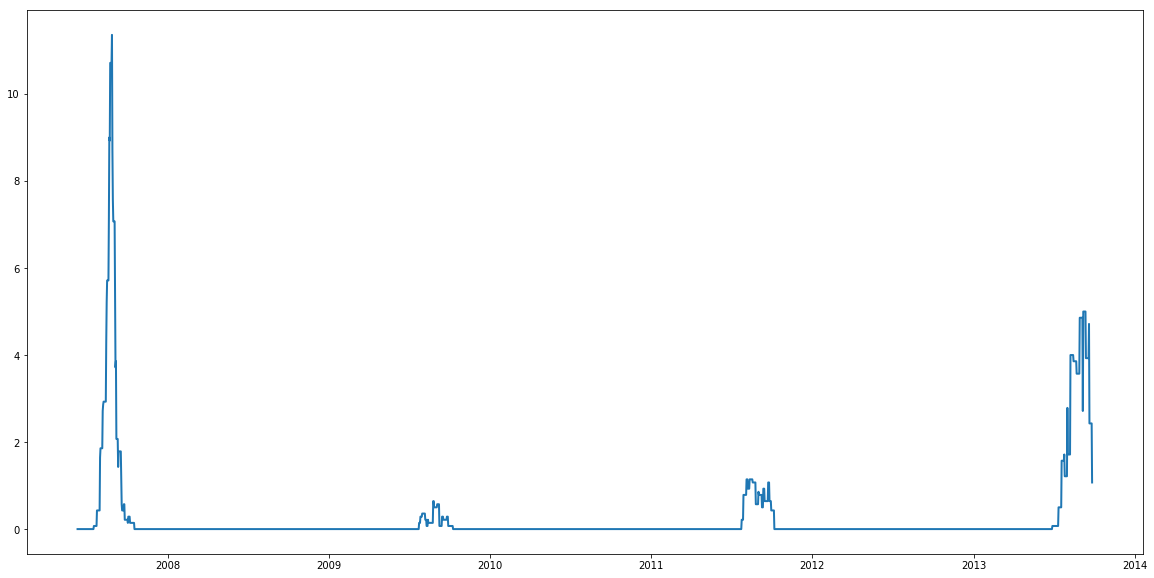

In [40]:
# 2007 and 2013 had more occurances of west nile than 2009 and 2011
plt.figure(figsize=(20,10))
plt.plot(df_train['WnvPresent'].resample('D').sum().rolling(window=14).mean(), alpha=1, lw=2)

### 1.2.2 Additional Feature Research after Initial Model

# <a class="anchor" id="2.0-bullet">2. Data Transformation </a>

## 2.1 Weather Slice

There are two weather stations in the main weather file: 1 for O'hare and 2 for Midway.
O'hare is a more complete dataset, so we will start by using only this location.

In [6]:
weather_station_1 = data_weather.loc[data_weather.Station==1, :]
weather_station_2 = data_weather.loc[data_weather.Station==2, :]

In [7]:
weather_station_1 = weather_station_1.drop('Station', axis=1)
weather_station_2 = weather_station_2.drop('Station', axis=1)

In [8]:
# Convert Date to datetime format 
weather_station_1.loc[:, ['Date']] = pd.to_datetime(weather_station_1.Date)
weather_station_2.loc[:, ['Date']] = pd.to_datetime(weather_station_2.Date)

In [9]:
# Set index to Date
weather_station_1.index = weather_station_1.Date
weather_station_2.index = weather_station_2.Date

## 2.2 Weather Convert Objects

In [10]:
# Convert Avg Temperature to float
weather_station_1.loc[:, ['Tavg']] = weather_station_1['Tavg'].astype('float64')

In [11]:
# Convert Trace amount of rainfall and Precip from 'T' to value
weather_station_1.loc[:, ['PrecipTotal']] = \
weather_station_1['PrecipTotal'].map(lambda x: .001 if x=='  T' else x).astype(float)
weather_station_1.loc[:, ['SnowFall']] = \
weather_station_1['SnowFall'].map(lambda x: .001 if x=='  T' else x).astype(float)

In [12]:
# Drop unecessary columns
weather_station_1 = weather_station_1.drop('Depart', axis=1)
weather_station_1 = weather_station_1.drop('Water1', axis=1)

In [13]:
# There are three columns with a 'M' that will need to be replaced
weather_station_1[weather_station_1 == 'M'].count()

Date           0
Tmax           0
Tmin           0
Tavg           0
DewPoint       0
WetBulb        3
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
SnowFall       0
PrecipTotal    0
StnPressure    2
SeaLevel       5
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [14]:
# ONLY RUN THIS CELL ONCE
#find means without 'M' values and fill in blank - less than 5 for each
stnpressure_mean = weather_station_1[weather_station_1['StnPressure']!='M']['StnPressure'].astype(float).mean()
sealevel_mean = weather_station_1[weather_station_1['SeaLevel']!='M']['SeaLevel'].astype(float).mean()
wetbulb_mean = weather_station_1[weather_station_1['WetBulb']!='M']['WetBulb'].astype(float).mean()

#Replace M with mean, leave others alone
weather_station_1.loc[:, 'StnPressure'] = \
weather_station_1['StnPressure'].map(lambda x: stnpressure_mean if x=='M' else x).astype(float);

weather_station_1.loc[:, 'SeaLevel'] = \
weather_station_1['SeaLevel'].map(lambda x: sealevel_mean if x=='M' else x).astype(float)

weather_station_1.loc[:, 'WetBulb'] = \
weather_station_1['WetBulb'].map(lambda x: wetbulb_mean if x=='M' else x).astype(float);

## 2.3 Complete Weather dataframe

In [15]:
weather_station_1.head()

,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,
2007-05-01,2007-05-01,83,50,67.0,51,56.0,0,2,0448,1849,,0,0.0,0.000,29.10,29.82,1.7,27,9.2
2007-05-02,2007-05-02,59,42,51.0,42,47.0,14,0,0447,1850,BR,0,0.0,0.000,29.38,30.09,13.0,4,13.4
2007-05-03,2007-05-03,66,46,56.0,40,48.0,9,0,0446,1851,,0,0.0,0.000,29.39,30.12,11.7,7,11.9
2007-05-04,2007-05-04,66,49,58.0,41,50.0,7,0,0444,1852,RA,0,0.0,0.001,29.31,30.05,10.4,8,10.8
2007-05-05,2007-05-05,66,53,60.0,38,49.0,5,0,0443,1853,,0,0.0,0.001,29.40,30.10,11.7,7,12.0


### 2.3.1 Addition Weather Features

In [16]:
#Create dummy columns for weather codes

#list all columns
templist = [element for element in weather_station_1['CodeSum'].str.split(' ').tolist()]
newl = []
#get all tags
for element in templist:
    for subelement in element:
        newl.append(subelement)
Codes_list = list(set(newl))
Codes_list.pop(0)

#Create new columns and score 1 if present in original CodeSum value
for code in Codes_list:
    weather_station_1.loc[:, code] = weather_station_1['CodeSum'].str.contains(code)*1
weather_station_1 = weather_station_1.drop('CodeSum', axis=1)

In [17]:
#Convert remaining cols to float. Leftover errors from station 2
obj_cols = [col for col in weather_station_1.columns if weather_station_1[col].dtype=='object']
for col in weather_station_1:
    if col in obj_cols:
        weather_station_1.loc[:, col] = weather_station_1[col].astype('float64')

### 2.3.2 Ws 2

In [20]:
weather_station_2 = weather_station_2.drop(['Depart', 'Depth', 'Water1', 'SnowFall'], axis=1)

In [21]:
Mcols=[]
for col in weather_station_2.columns:
    try:
        if weather_station_2[weather_station_2[col]=='M'].shape[0] > 0:
            print('   ', col, weather_station_2[weather_station_2[col]=='M'].shape[0])
            Mcols.append(col)
    except:
        next

    Tavg 11
    WetBulb 1
    Heat 11
    Cool 11
    PrecipTotal 2
    StnPressure 2
    SeaLevel 4
    AvgSpeed 3


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1164: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [22]:
# Convert Trace amount of rainfall and Precip from 'T' to value
weather_station_2.loc[:, ['PrecipTotal']] = \
weather_station_2['PrecipTotal'].map(lambda x: .001 if x=='  T' else x)


In [23]:
Mcols

['Tavg',
 'WetBulb',
 'Heat',
 'Cool',
 'PrecipTotal',
 'StnPressure',
 'SeaLevel',
 'AvgSpeed']

In [24]:
for col in Mcols:
    tempmean =  weather_station_2[weather_station_2[col]!='M'][col].astype(float).mean()
    weather_station_2.loc[:, col] = \
weather_station_2[col].map(lambda x: tempmean if x=='M' else x).astype(float)

In [25]:
weather_station_2.dtypes

Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                  float64
DewPoint                int64
WetBulb               float64
Heat                  float64
Cool                  float64
Sunrise                object
Sunset                 object
CodeSum                object
PrecipTotal           float64
StnPressure           float64
SeaLevel              float64
ResultSpeed           float64
ResultDir               int64
AvgSpeed              float64
dtype: object

In [26]:
#Create dummy columns for weather codes

#list all columns
templist = [element for element in weather_station_2['CodeSum'].str.split(' ').tolist()]
newl = []
#get all tags
for element in templist:
    for subelement in element:
        newl.append(subelement)
Codes_list = list(set(newl))
Codes_list.pop(0)

#Create new columns and score 1 if present in original CodeSum value
for code in Codes_list:
    weather_station_2.loc[:, code] = weather_station_2['CodeSum'].str.contains(code)*1
weather_station_2 = weather_station_2.drop('CodeSum', axis=1)

In [27]:
#Not using these anyway
weather_station_2 = weather_station_2.drop(['Sunrise', 'Sunset'], axis=1)

In [28]:
ws1_output = weather_station_1
ws1_output['StationNum'] = 1
ws2_output = weather_station_2
ws2_output['StationNum'] = 2

ws_combo = pd.concat([ws1_output, ws2_output])

#ws_combo.to_csv('./Data/WeatherStations.csv', index=False)

## 2.2 Training Data Munging

We will need to combine the train and test data with relevant addtional information for the weather and spray datasets.

This will be done by combine dataset using the index after it has been set to the date.


### 2.2.1 Time Series

#### 2.2.1.1 Basic Conversion

In [18]:
#Create Days from start column for easy analysis
BeginDate = datetime.date(2007, 4, 30)
df_train.loc[:, 'DaysFrom'] = df_train.index - pd.to_datetime(BeginDate)
#extract date number from datetime entry. Should capture broad time dependence
df_train.loc[:, 'DaysFrom'] = df_train['DaysFrom'].astype(str).str.replace(' days 00:00:00.000000000', '').astype(int)
#Extract Month information
df_train.loc[:, 'Month'] = df_train.index.month

#### 2.2.1.2 Seasonal Adjustments to Baseline Probability

In [19]:
#Create a normalized graph to observe seasonality across years
year_day = pd.DataFrame(df_train.index.dayofyear)
year_day['Wnv'] = pd.DataFrame(df_train['WnvPresent']).reset_index().drop('Date', axis=1)
#Total number of occurences by day of the year
daily_sums = year_day.groupby(by='Date').sum()

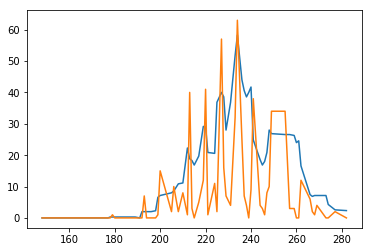

In [20]:
#Shift up two days to capture Friday-Monday jump
#2 seems to be an appropriate normalization factor
normizer = 2
rolls = pd.Series([daily_sums.iloc[row-5:row+2].mean().sum()*normizer for row in range(len(daily_sums))])
rolls.index = daily_sums.index
plt.plot(rolls)
plt.plot(year_day.groupby(by='Date').sum());#confirm this is from skipped weekends or something

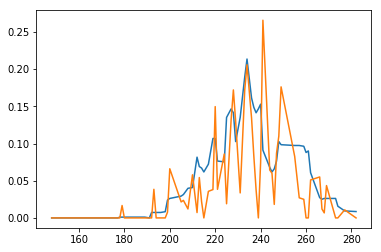

In [21]:
#Normalize by total rows used in calculation
rolling_count = year_day.groupby(by='Date').count()
rolling_average_rate = rolls / rolling_count['Wnv'].mean()/normizer
plt.plot( rolling_average_rate)
plt.plot(year_day.groupby(by='Date').sum() /rolling_count)

In [22]:
np.mean(list(rolls.index))

214.01298701298703

In [23]:
mu, std = sp.stats.norm.fit(list(rolls.index))

In [144]:
df_combined.index.dayofyear.max()

282

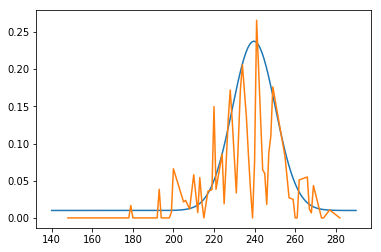

In [145]:
norm_list = []
_min = 140
_max = 290
for i in range(_min, _max):
    norm_list.append(6*sp.stats.norm.pdf(i-25, mu, std/3.5)+.01)

plt.plot(np.linspace(_min, _max, len(norm_list)), norm_list)
plt.plot(year_day.groupby(by='Date').sum() /rolling_count)

In [146]:
seasonal_dict = {}
for i in range(len(norm_list)):
    seasonal_dict[140+i] = norm_list[i]
seasonal_dict[147]

0.010000000000000005

### 2.2.2 Combine with weather data

In [28]:
#Create rolling average for all weather columns.
weather_rolling_7 = weather_station_1.resample('D').sum().rolling(window=7).mean().shift()

In [29]:
#Weather Data as is
weather_rolling_1 = weather_station_1.resample('D').sum()

In [30]:
weather_rolling_14 = weather_station_1.resample('D').sum().rolling(window=14).mean()

### 2.2.3 Dummy Columns

In [31]:
df_species_dummies = pd.get_dummies(df_train['Species'])
df_trap_dummies = pd.get_dummies(df_train['Trap'])

## 2.3 Final Concatention

In [32]:
#CAUTION: JOINING DATAFRAMES IS MEMORY INTENSIVE

In [33]:
#YOU HAVE BEEN WARNED

In [169]:
#Using left join to only include weather rows that are in training set
df_combined = df_train.join(weather_rolling_7, how='left')

In [170]:
df_combined = pd.concat([df_combined,df_species_dummies], axis=1)

In [171]:
cols_to_drop = ['Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'AddressAccuracy', 'Date']
df_combined = df_combined.drop(cols_to_drop, axis=1)

In [172]:
#Add measurement back in 
df_combined['YearDay'] = df_train.index.dayofyear

rolling_average_rate = pd.DataFrame(rolling_average_rate, columns=['seasonal_baseline'])

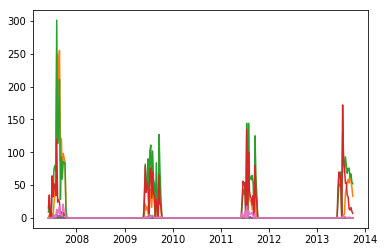

In [38]:

plt.plot(df_species_dummies.resample('W').sum().rolling(window=1).mean())

# <a class="anchor" id="3.0-bullet">3. Model </a>

### 3.0.1 Analysis Setup

In [250]:
# Function that makes confusion matrix and outputs ROC score
def make_pretty_conmat(y_test, predictions):
    conmat = confusion_matrix(y_test, predictions)
    conmat_df = pd.DataFrame(conmat, columns=['Predicted 0', 'Pred 1'], index=['Actual 0', 'Actual 1'])
    conmat_df = conmat_df.add_prefix('Predicted: ')
    print(f"ROC score: {roc_auc_score(y_test, predictions)}")
    return conmat_df

In [251]:
# Runs and outputs results into dataframe of any model input along with train/test data
def roc_calculate(model,X_train,y_train,X_test, y_test):
    df_roc = pd.DataFrame(columns=['models','train', 'test'])
    for mod in range(0,len(model)):
        # Set and fit model from list
        use_model = model[mod]
        use_model.fit(X_train,y_train)
        # Create predictions
        y_train_predicted = use_model.predict_proba(X_train)
        y_test_predicted = use_model.predict_proba(X_test)
        #Isolate positive prediction values 
        wnv_train_preds = [proba[1] for proba in y_train_predicted]
        wnv_test_preds = [proba[1] for proba in y_test_predicted]
        #Score and save value
        train = roc_auc_score(y_train, wnv_train_preds)
        test = roc_auc_score(y_test, wnv_test_preds)
        # Set name and add to dataframe
        name = str(model[mod])
        df_roc.loc[len(df_roc)] = [name, train, test]
    return df_roc

## 3.1 Initial Model

In [173]:
weather_cols = ['Tmax', 'WetBulb', 'PrecipTotal', 'AvgSpeed']

# Set columns to exlude from features matrix
cols_to_exclude = ['Date','WnvPresent', 'NumMosquitos', 'DaysFrom', 
                   'Sunrise', 'Sunset', 'Month', 'seasonal_baseline','Address',
                   'Species', 'Block','Street','Trap', 'AddressAccuracy', 'AddressNumberAndStreet', 'YearDay'
                  ]

for element in weather_rolling_7.columns:
    if element not in weather_cols:
        cols_to_exclude.append(element)

model_cols = [col for col in df_combined.columns if col not in cols_to_exclude]

In [174]:
# Set X and y matrices
X = df_combined.loc[:, model_cols]
y = df_train['WnvPresent']

cols_to_normalize = model_cols
norm_dict = {}
for col in cols_to_normalize:
    _df_cur = X.loc[:, col]
    _mean = _df_cur.mean()
    _std = _df_cur.std()
    #Store for test data transform
    norm_dict[col] = [_mean, _std]

    X.loc[:, col] = (X.loc[:, col] - _mean) / _std
    

#Stratification on Days From should ensure usable spread in time data. Should get most periods in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X.index, random_state=42)

In [54]:
# List of initial classifiers to review
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(n_neighbors=8),
    BaggingClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42)]

In [175]:
# This baseline model input features are:
# 1) As is Weather Data (no rolling)
# 2) Location only by cordianates
# 3) Dummy by Species
# 4) Dummy by Trap Name
roc_calculate(classifiers,X_train,y_train,X_test,y_test)

,models,train,test
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.746191,0.762964
1,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.915516,0.743495
2,"BaggingClassifier(base_estimator=None, bootstr...",0.989752,0.719520
3,"RandomForestClassifier(bootstrap=True, class_w...",0.990599,0.728316
4,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",0.829591,0.812423


## 3.2 Models after Feature Engineering

In [104]:
knc = KNeighborsClassifier(n_neighbors=15)

knc.fit(X_train, y_train)

proba_array = [proba[1] for proba in knc.predict_proba(X_test)]

adj_score = pd.Series(X_test.index.dayofyear, index=X_test.index).map(lambda x: seasonal_dict[x])

roc_auc_score(y_test, proba_array)

In [176]:
from sklearn.model_selection import GridSearchCV

In [201]:
paramz = {
    'penalty': ['l2'],
    'C': [.01, .001, .02],
    'solver' : ['liblinear', 'newton-cg', 'lbfgs']
}

gs = GridSearchCV(LogisticRegression(), param_grid=paramz)

In [202]:
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2'], 'C': [0.01, 0.001, 0.02], 'solver': ['liblinear', 'newton-cg', 'lbfgs']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [203]:
gs.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}

In [237]:
proba_array = [proba[1] for proba in gs.predict_proba(X_test)]

adj_score = pd.Series(X_test.index.dayofyear, index=X_test.index).map(lambda x: seasonal_dict[x])

print('   base: ', roc_auc_score(y_test, proba_array))
print('   seasonal: ', roc_auc_score(y_test, proba_array + adj_score))

   base:  0.7480591291783601
   seasonal:  0.7740670760510157


In [239]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

proba_array = [proba[1] for proba in logreg.predict_proba(X_test)]

adj_score = pd.Series(X_test.index.dayofyear, index=X_test.index).map(lambda x: seasonal_dict[x])

print('   base: ', roc_auc_score(y_test, proba_array))
print('   seasonal: ', roc_auc_score(y_test, proba_array + adj_score))

   base:  0.7629636833476896
   seasonal:  0.7812609408430353


In [238]:
results_dict = {}
for i in range(5,25, 2):
    knc = KNeighborsClassifier(n_neighbors = i)
    knc.fit(X_train, y_train)

    knc_probas = []
    knc_array = knc.predict_proba(X_test)
    for j in range(len(X_test)):
        knc_probas.append(knc_array[j][1]+adj_score[i])
    _result = roc_auc_score(y_test, knc_probas)
    results_dict[i] = _result
    print('    neighbors: {}, score: {}'.format(i,_result ))

    neighbors: 5, score: 0.692765845119342
    neighbors: 7, score: 0.72767929089444
    neighbors: 9, score: 0.7459959987774042
    neighbors: 11, score: 0.7614090416516158
    neighbors: 13, score: 0.7600836366667593
    neighbors: 15, score: 0.7636583400483481
    neighbors: 17, score: 0.7587957431437384
    neighbors: 19, score: 0.7617146905999055
    neighbors: 21, score: 0.7683208758231683
    neighbors: 23, score: 0.7690433187918531


In [48]:
result_x, result_y = zip(*sorted(results_dict.items()))

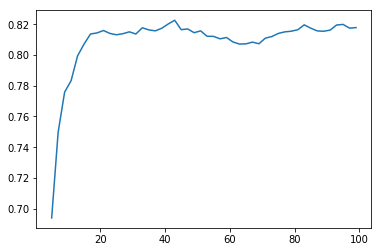

In [49]:
plt.plot(result_x, result_y)

## 3.3 Final Model Selection

In [205]:
our_model = gs

In [370]:
'''our_model = KNeighborsClassifier(n_neighbors=15)

our_model.fit(X_train, y_train)'''

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


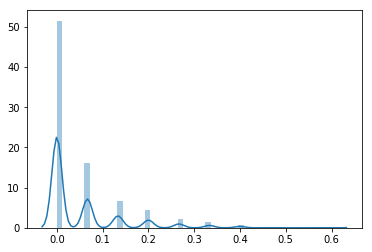

# <a class="anchor" id="4.0-bullet">4. Output</a>

## 4.1 Transform test data

In [208]:
df_test = data_test
df_test.shape

(116293, 11)

### 4.1.1 Time Series

In [209]:
#Convert to Date Time from object
df_test.loc[:, ['Date']]= pd.to_datetime(df_test['Date'])

#Switch to DateTime Index
df_test.index = df_test.Date

#Create Days from start column for easy analysis

df_test.loc[:, 'DaysFrom'] = df_test.index - pd.to_datetime(BeginDate)
#extract date number from datetime entry. Should capture broad time dependence
df_test.loc[:, 'DaysFrom'] = df_test['DaysFrom'].astype(str).str.replace(' days 00:00:00.000000000', '').astype(int)
#Extract Month information
df_test.loc[:, 'Month'] = df_test.index.month

df_test['YearDay'] = df_test.index.dayofyear

In [210]:
#Get weekday dummies
'''df_test_weekday = pd.get_dummies(df_test.index.weekday_name)
df_test_weekday.index = df_test.index
df_test = pd.concat([df_test, df_test_weekday], axis=1)'''

'df_test_weekday = pd.get_dummies(df_test.index.weekday_name)\ndf_test_weekday.index = df_test.index\ndf_test = pd.concat([df_test, df_test_weekday], axis=1)'

In [211]:
#Need to do some math to include seasonality here. Some yeardays in test not in training.

### 4.1.2 Categorical

In [212]:
df_test_species = pd.get_dummies(df_test['Species'])
[col for col in df_test_species.columns if col not in df_species_dummies.columns]

['UNSPECIFIED CULEX']

In [213]:
df_test_species = df_test_species.drop('UNSPECIFIED CULEX', axis=1)
df_test = pd.concat([df_test,df_test_species], axis=1)

In [214]:
df_test_trap = pd.get_dummies(df_test['Trap'])
df_test = pd.concat([df_test,df_test_trap], axis=1)

### 4.1.3 Weather

In [215]:
df_test = df_test.join(weather_rolling_1, how='left')

### 4.1.4 Drops

In [216]:
df_test = df_test.drop(cols_to_drop, axis=1)

In [217]:
combo = pd.concat([df_combined , combo]).fillna(0)

NameError: name 'combo' is not defined

In [404]:
combo['DateT'] = combo.index

In [405]:
df_test['CULEX PIPIENS'].sum()

14521

In [179]:
combo.to_csv('./Data/TrainTest_917_A.csv')

In [174]:
combo = None

#  <a class="anchor" id="5.0-bullet">5. Kaggle Submission</a>

## 5.1 Fit to Test Data

In [218]:
df_test_X = df_test.loc[:, model_cols]
[col for col in df_test_X.columns if col not in X.columns]

[]

### normalize

In [219]:
norm_dict

{'Latitude': [41.84113928973943, 0.11274152662546437],
 'Longitude': [-87.69990798325082, 0.0965141689871595],
 'Tmax': [80.69458268744476, 5.8991849445029505],
 'WetBulb': [63.98740103944431, 5.105050066186582],
 'PrecipTotal': [0.16347190720948068, 0.25629692209134747],
 'AvgSpeed': [7.565275624813138, 1.1332450723064764],
 'CULEX ERRATICUS': [9.518370454978108e-05, 0.009756213637973549],
 'CULEX PIPIENS': [0.25690081857985914, 0.4369450315052907],
 'CULEX PIPIENS/RESTUANS': [0.4523129640205597, 0.49774444076996116],
 'CULEX RESTUANS': [0.26080335046640013, 0.4390937423667433],
 'CULEX SALINARIUS': [0.008185798591281173, 0.09010862413164791],
 'CULEX TARSALIS': [0.0005711022272986865, 0.02389205732659112],
 'CULEX TERRITANS': [0.0211307824100514, 0.14382712344298532]}

In [220]:
for col in cols_to_normalize:
    _mean = norm_dict[col][0]
    _std = norm_dict[col][1]
    #Store for test data transform
    #norm_dict[col] = [_mean, _std]

    df_test_X.loc[:, col] = (df_test_X.loc[:, col] - _mean) / _std

In [221]:
df_test_X.isnull().sum()

Latitude                  0
Longitude                 0
Tmax                      0
WetBulb                   0
PrecipTotal               0
AvgSpeed                  0
CULEX ERRATICUS           0
CULEX PIPIENS             0
CULEX PIPIENS/RESTUANS    0
CULEX RESTUANS            0
CULEX SALINARIUS          0
CULEX TARSALIS            0
CULEX TERRITANS           0
dtype: int64

In [222]:
df_test_preds = our_model.predict(df_test_X)

In [223]:
df_test_prob_array = our_model.predict_proba(df_test_X)

In [226]:
df_test_probas = [proba[1] for proba in df_test_prob_array]

In [228]:
sum(df_test_probas)

3477.4540178884317

## 5.2 Assess

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


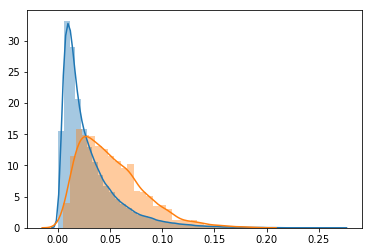

In [230]:
df_test_preds_adj =pd.Series(df_test_X.index.dayofyear, index=df_test_X.index).map(lambda x: seasonal_dict[x])

In [231]:
print('   base model WNV predicitons: ', df_test_preds.sum())
print('   adusted proba WNV predictions: ', sum(df_test_preds_adj))
print('   predicted rate WNV adjusted: ', sum(df_test_preds_adj)/len(df_test_preds_adj))

   base model WNV predicitons:  0
   adusted proba WNV predictions:  7443.0995313341555
   predicted rate WNV adjusted:  0.06400298841146204


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


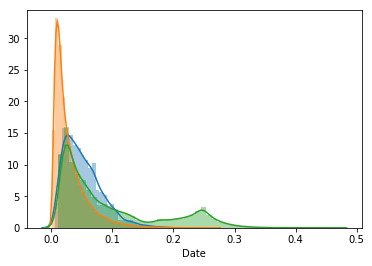

In [249]:
sns.distplot([proba[1] for proba in our_model.predict_proba(X_test)])
sns.distplot(df_test_probas)
sns.distplot(df_test_preds_adj+df_test_probas)

In [244]:
len(df_test_probas)

116293

## 5.3 Create Submission File

In [245]:
df_outputs = pd.DataFrame(df_test.Id)
df_outputs['WnvPresent'] = df_test_probas+df_test_preds_adj
df_outputs = df_outputs.reset_index().drop('Date', axis=1)

In [246]:
now_month = datetime.datetime.now().month
now_day = datetime.datetime.now().day
now_hour = datetime.datetime.now().hour
now_minute = datetime.datetime.now().minute
output_title = './Predictions/Predictions_{}.{}_{}{}.csv'.format(now_month, now_day, now_hour, now_minute)

In [247]:
df_outputs.to_csv(output_title, index=False)